In [1]:
%%html
<style> body { font-family: "Times New Roman"} </style>

In [2]:
%matplotlib inline
import dask
from dask import dataframe as dd 
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/home/mmora/anaconda3/lib/python3.7/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Carga de datos

In [37]:
df = pd.read_csv('DATA_CRAN/CRAN_DATA_20191231.csv', sep='|', low_memory=False)
df.shape

(91321, 39)

In [5]:
df.head()

,Author,Authors@R,BugReports,Date,Date/Publication,Depends,Description,Encoding,Imports,LazyData,...,releases,DatePublication,Year/Publication,Month/Publication,Day/Publication,Year_Month/Publication,NumberOfImports,NumberOfDepends,NumberOfSuggests,NumberOfLinkingTo
0,Scott Fortmann-Roe,NaN,NaN,2013-02-06,2013-02-07 10:00:27,"['xtable', 'pbapply']",This package supplies tools for tabulating and...,NaN,[],NaN,...,['2.15.3'],2013-02-07,2013,2,7,2013-02,0,2,2,0
1,Scott Fortmann-Roe,NaN,NaN,2013-03-24,2013-03-26 19:58:40,"['R', 'xtable', 'pbapply']",This package supplies tools for tabulating and...,NaN,[],NaN,...,"['3.0.0', '3.0.1', '3.0.2', '3.0.3', '3.1.0', ...",2013-03-26,2013,3,26,2013-03,0,3,2,0
2,Scott Fortmann-Roe,NaN,NaN,2015-08-15,2015-08-16 23:05:52,"['R', 'xtable', 'pbapply']",Supplies tools for tabulating and analyzing th...,NaN,[],NaN,...,[],2015-08-16,2015,8,16,2015-08,0,3,2,0
3,Raja Sekhara Reddy D.M,NaN,NaN,NaN,2019-08-01 09:10:06 UTC,['R'],"Given a protein multiple sequence alignment, i...",UTF-8,"['DT', 'networkD3', 'shiny', 'shinydashboard',...",true,...,[],2019-08-01,2019,8,1,2019-08,9,1,2,0
4,Raja Sekhara Reddy D.M,NaN,NaN,NaN,2019-11-09 16:20:02 UTC,['R'],"Given a protein multiple sequence alignment, i...",UTF-8,"['DT', 'networkD3', 'shiny', 'shinydashboard',...",true,...,[],2019-11-09,2019,11,9,2019-11,9,1,2,0


In [6]:
df['DatePublication'] = pd.to_datetime(df['Date/Publication'], utc=True).dt.strftime("%Y-%m-%d")
df['Year_Month/Publication'] = pd.to_datetime(df['Year_Month/Publication']).dt.strftime("%Y-%m-%d")

Filtramos los datos para no incluir el año 2019, pues no se dipone de información del año completo

In [7]:
dfl = df.loc[ (df['Year/Publication'] > 1998)]

In [8]:
dfl_MPC = df.groupby('Year_Month/Publication')[['Package']].count()
dfl_MPC = dfl_MPC.rename(columns={'Package': 'NumberOfPackages'})
dfl_MPC.reset_index(inplace=True)
dfl_MPC['Year/Publication'] = pd.DatetimeIndex(dfl_MPC['Year_Month/Publication']).year

In [9]:
dfl_MP = dfl.groupby('Year_Month/Publication')[['Package']].count()
dfl_MP = dfl_MP.rename(columns={'Package': 'NumberOfPackages'})
dfl_MP.reset_index(inplace=True)
dfl_MP['Year/Publication'] = pd.DatetimeIndex(dfl_MP['Year_Month/Publication']).year

Datos de la Serie Temporal

In [10]:
dfl_MP.head(10)

,Year_Month/Publication,NumberOfPackages,Year/Publication
0,1999-01-01,2,1999
1,1999-02-01,1,1999
2,1999-03-01,1,1999
3,1999-04-01,20,1999
4,1999-05-01,4,1999
5,1999-06-01,2,1999
6,1999-07-01,10,1999
7,1999-08-01,7,1999
8,1999-09-01,1,1999
9,1999-10-01,2,1999


In [11]:
dfl_MP.shape

(252, 3)

# Verificando la estacionariedad de la serie

Una serie temporal es estacionaria si su media y varianza son constantes a través del tiempo. Una serie cuya media y varianza cambian a través del tiempo es una serie no estacionaria. Para determinar si la serie es estacionaria podemos empezar graficando la serie. En la siguiente figura observamos que los valores no fluctúan con variación constante, entonces es razonable pensar que la serie es no estacionaria.

## Visualización de datos

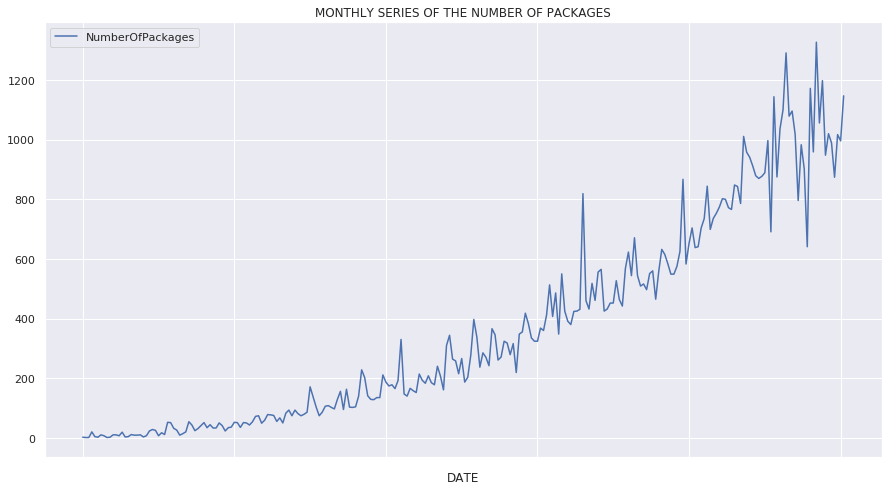

In [12]:
ax = dfl_MP.set_index('Year_Month/Publication')[['NumberOfPackages']].plot(figsize=(15, 8))
ax.set(title="MONTHLY SERIES OF THE NUMBER OF PACKAGES", 
       xlabel="DATE");

Comparación del año 2011 y 2012

In [13]:
df_2011 = df[df['Year/Publication'] == 2011].groupby('Year_Month/Publication')[['Package']].count().reset_index()
df_2012 = df[df['Year/Publication'] == 2012].groupby('Year_Month/Publication')[['Package']].count().reset_index()

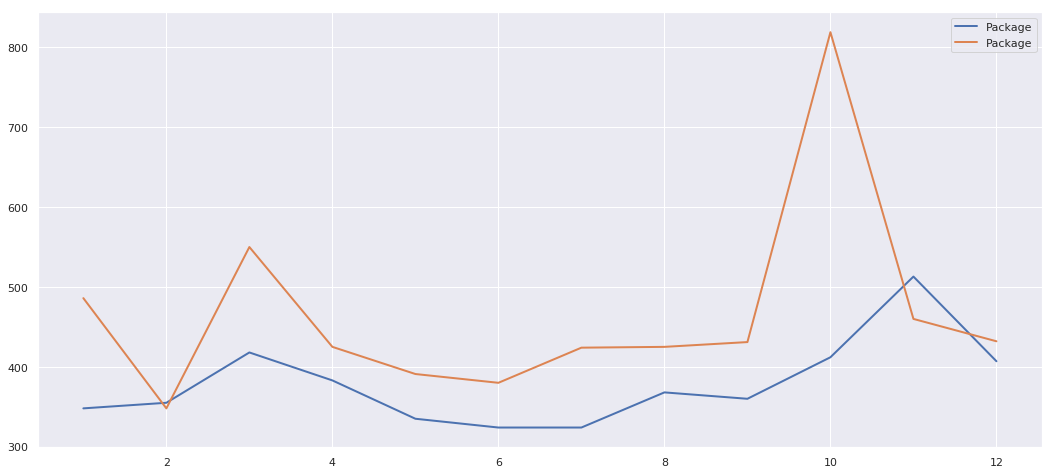

In [14]:
plt.figure(figsize=(18,8))

plt.plot(np.array(df_2011.index + 1), 'Package', data=df_2011, marker='', linewidth=2)
plt.plot(np.array(df_2012.index + 1), 'Package', data=df_2012, marker='', linewidth=2)
plt.legend()

Otra manera de visualizar los datos de la serie es la función *seasonal_decompose()* en statsmodel. Con esto, la tendencia y la estacionalidad se pueden aprecir mejor.

## Descomposición estacional

El procedimiento *descomposición estacional* descompone la serie en sus componentes estacionales, un componente de ciclo y tendencia, así como un componente de "error". 

In [15]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('OBSERVED')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('TREND')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('SEASONAL')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('RESIDUAL')
    axes[3].set_xlabel('DATE')

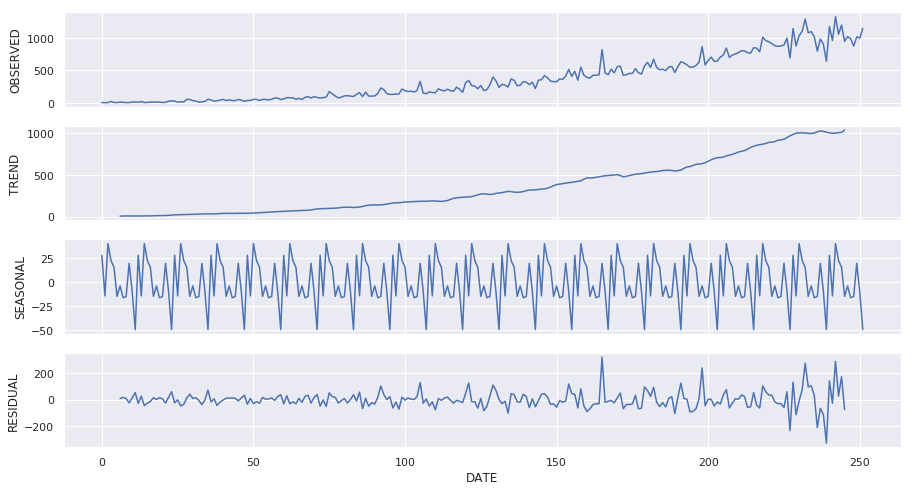

In [16]:
decomposition = seasonal_decompose(dfl_MP['NumberOfPackages'], freq=12)  
fig, axes = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(15, 8)
plotseasonal(decomposition, axes)

In [17]:
dfl_MP.head()

,Year_Month/Publication,NumberOfPackages,Year/Publication
0,1999-01-01,2,1999
1,1999-02-01,1,1999
2,1999-03-01,1,1999
3,1999-04-01,20,1999
4,1999-05-01,4,1999


En el gráfico anterior, se puede observar una tendencia lineal positiva y una componente estacional anual. El componente estacional nos dice que el primer mes del año (Enero) se publican un número alto de paquetes, el segundo mes (Febrero) este número baja y vuelve a subir en los próximos meses (alcanza el número más alto de paquetes publicados) hasta Mayo y luego las publicaciones empiezan a disminuir hasta que el año termina. En el siguiente gráfico se puede observar la componene estacional un poco más clara.

<Figure size 432x288 with 0 Axes>

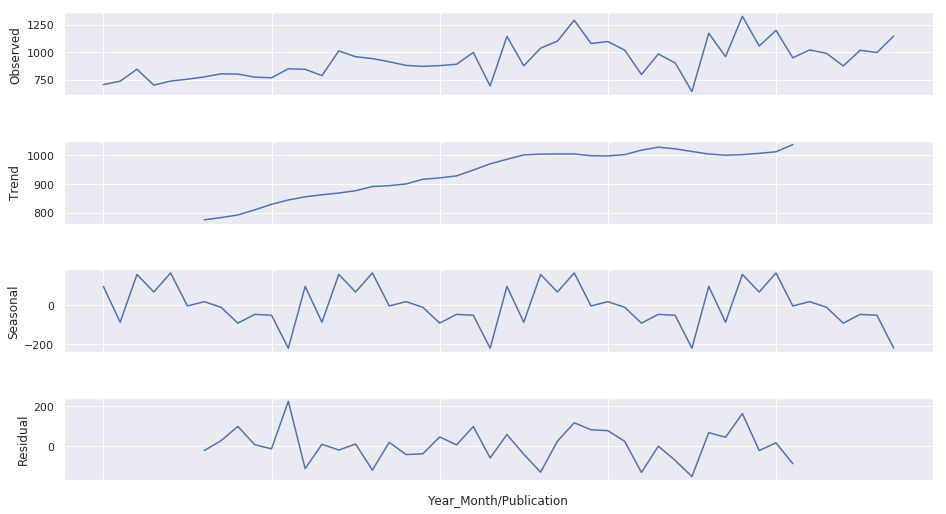

In [18]:
dfl_YMP = df[df['Year/Publication'] >= 2016].groupby('Year_Month/Publication')[['Package']].count()
dfl_YMP = dfl_YMP.rename(columns={'Package': 'NumberOfPackages'})

decomposition = seasonal_decompose(dfl_YMP[['NumberOfPackages']], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Prueba de estacionalidad

In [19]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Determing rolling statistics
        rolmean = timeseries.rolling(12).mean()
        rolstd = timeseries.rolling(12).std()

        #Plot rolling statistics:
        plt.figure(figsize=(16,8))
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')


        plt.legend(loc='best')
        plt.title('ROLLING MEAN & STANDARD DEVIATION')
        plt.show(block=False)
    
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'% key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

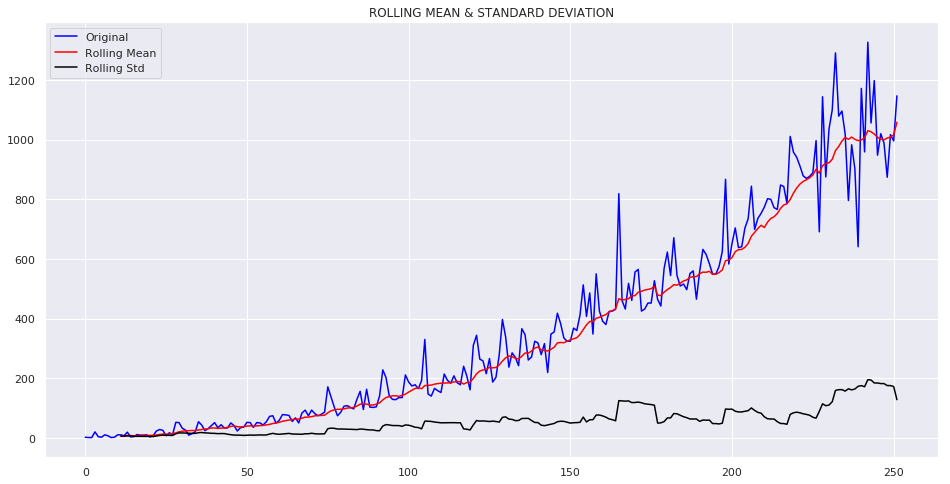

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        2.962933
P-Value                   1.000000
# Lags Used              14.000000
# Observations Used     237.000000
Critical Value (1%)      -3.458247
Critical Value (5%)      -2.873814
Critical Value (10%)     -2.573311
dtype: float64
¿LA SERIE ES ESTACIONARIA? False


In [20]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(dfl_MP['NumberOfPackages'], printResults = True)
print("¿LA SERIE ES ESTACIONARIA? {0}".format(sTest.isStationary))

* H0: Tiene raíz unitaria (No es estacionaria)
* H1: No tiene raíz unitaria (Es estacionaria)

En este caso el valor Test Statistic es 3,59 es mayor que el valor crítico del 5% por lo no rechazamos la hipótesis nula. Es decir afirmamos que la serie es no estacionaria.

# Estacionarizar los datos

Ya que el enfoque experimental propuesto es el modelo ARIMA estacional y los datos que estamos utilizando corresponden a una serie no estacionaria, es necesario hacer transformaciones sobre la serie para inducirla a ser estacionaria, esto se puede conseguir aplicando logaritmos para corregir heterocedasticidad (es decir, la varianza de los errores no es constante), la difenciación regular para eliminar tendencia (es decir, induce estacionariedad en media) y la diferenciación estacional para eliminar componente estacional.

La primera transformación que haremos es para eliminar la tendencia (o lo que es lo mismo, inducir estacionariedad en media), para ello se toma una primera diferenciación de los datos. La diferencia regular consiste en calcular la diferencia entre cada dato (por ejemplo, mensual) y el anterior.

In [21]:
#dfl_MP['LogNumberOfPackages'] = np.log(dfl_MP['NumberOfPackages'])

In [21]:
dfl_MP['first_difference'] = dfl_MP['NumberOfPackages'] - dfl_MP['NumberOfPackages'].shift(1)  

Como podemos ver ahora en la serie ya se ha eliminado la componente de tendencia

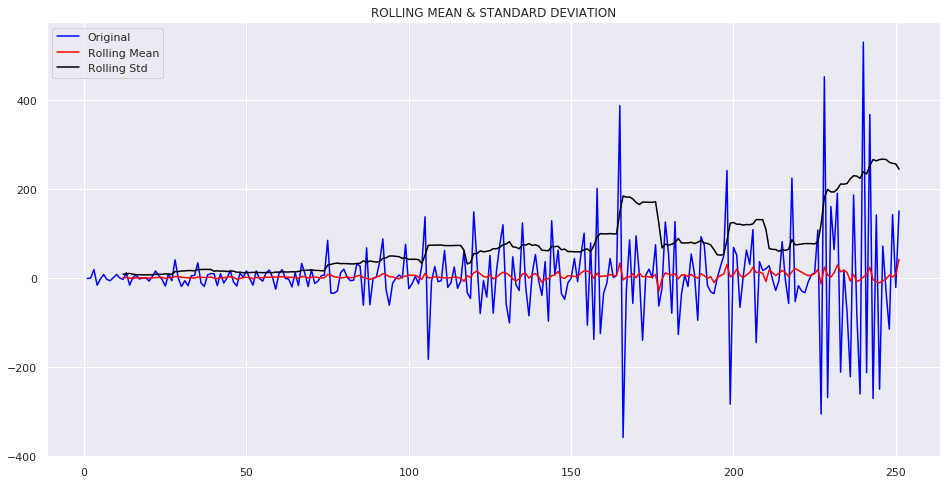

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -5.328728
P-Value                   0.000005
# Lags Used              13.000000
# Observations Used     237.000000
Critical Value (1%)      -3.458247
Critical Value (5%)      -2.873814
Critical Value (10%)     -2.573311
dtype: float64


In [22]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(dfl_MP['first_difference'].dropna(inplace=False), printResults = True)

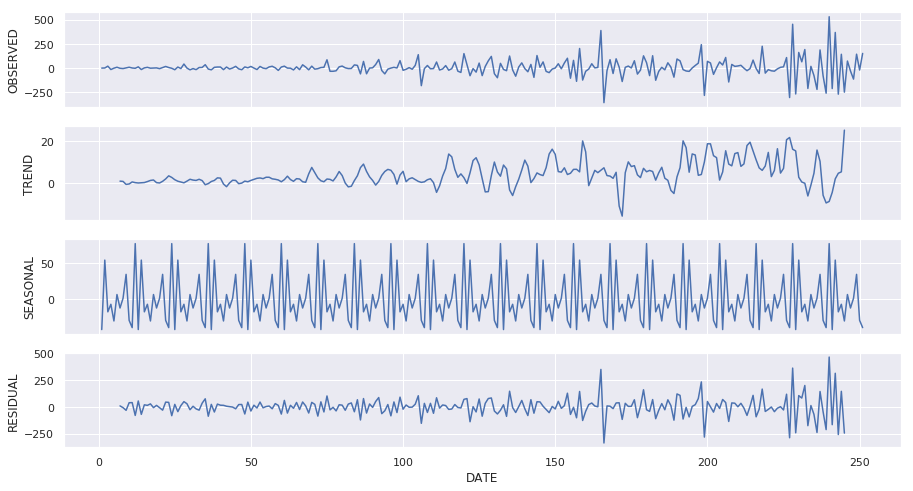

In [23]:
decomposition = seasonal_decompose(dfl_MP['first_difference'].dropna(inplace=False), freq=12)  
fig, axes = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(15, 8)
plotseasonal(decomposition, axes)

En la gráfica anterior podemos observar que se ha inducido estacionariedad en media. Sin embargo, también se aprecia que persiste la componente estacional. Por lo que ahora se realiza la diferencia estacional para eliminar la estacionalidad de los datos.

In [24]:
dfl_MP['seasonal_first_difference'] = dfl_MP['first_difference'] - dfl_MP['first_difference'].shift(12)  

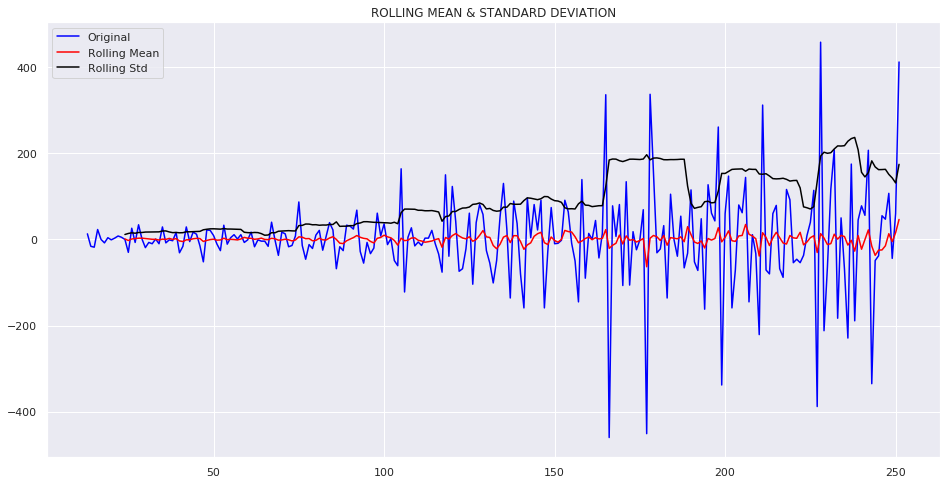

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -6.078800e+00
P-Value                 1.104931e-07
# Lags Used             1.500000e+01
# Observations Used     2.230000e+02
Critical Value (1%)    -3.460019e+00
Critical Value (5%)    -2.874590e+00
Critical Value (10%)   -2.573725e+00
dtype: float64
¿LA SERIE ES ESTACIONARIA? True


In [25]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(dfl_MP['seasonal_first_difference'].dropna(inplace=False), printResults = True)
print("¿LA SERIE ES ESTACIONARIA? {0}".format(sTest.isStationary))

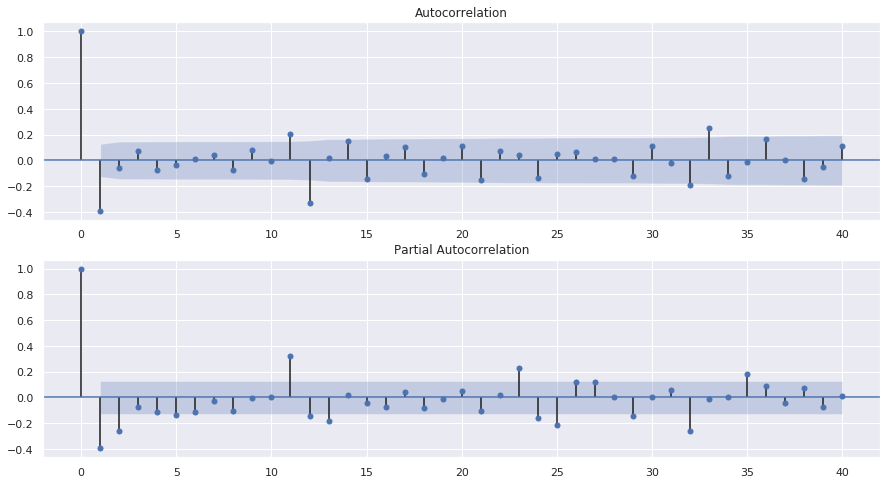

In [26]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfl_MP['seasonal_first_difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfl_MP['seasonal_first_difference'].iloc[13:], lags=40, ax=ax2)

# Selección de parámetros del modelo

Para seleccionar los parámetros para el modelo utilizamos la "búsqueda de cuadrícula" para explorar iterativamente diferentes combinaciones de parámetros. Para cada combinación de parámetros, se ajusta un nuevo modelo ARIMA estacional con lafunción del  SARIMAX() del módulo statsmodels de Python y evalua su calidad general. Una vez que se ha explorado todo el panorama de los parámetros, el conjunto óptimo de parámetros será el que produzca el mejor rendimiento para nuestros criterios de interés. 

In [27]:
import itertools

AIC = []
SARIMAX_model = []
p = q = d = range(0, 2)

# Genera todas las posibles combinaciones
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dfl_MP['NumberOfPackages'],
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

# Construcción del modelo

In [28]:
model = sm.tsa.statespace.SARIMAX(dfl_MP['NumberOfPackages'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=-1)
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   NumberOfPackages   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1370.890
Date:                            Thu, 20 Feb 2020   AIC                           2751.781
Time:                                    00:44:30   BIC                           2769.163
Sample:                                         0   HQIC                          2758.786
                                            - 252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0950      0.057      1.679      0.093      -0.016       0.206
ma.L1         -0.8844      0.032   

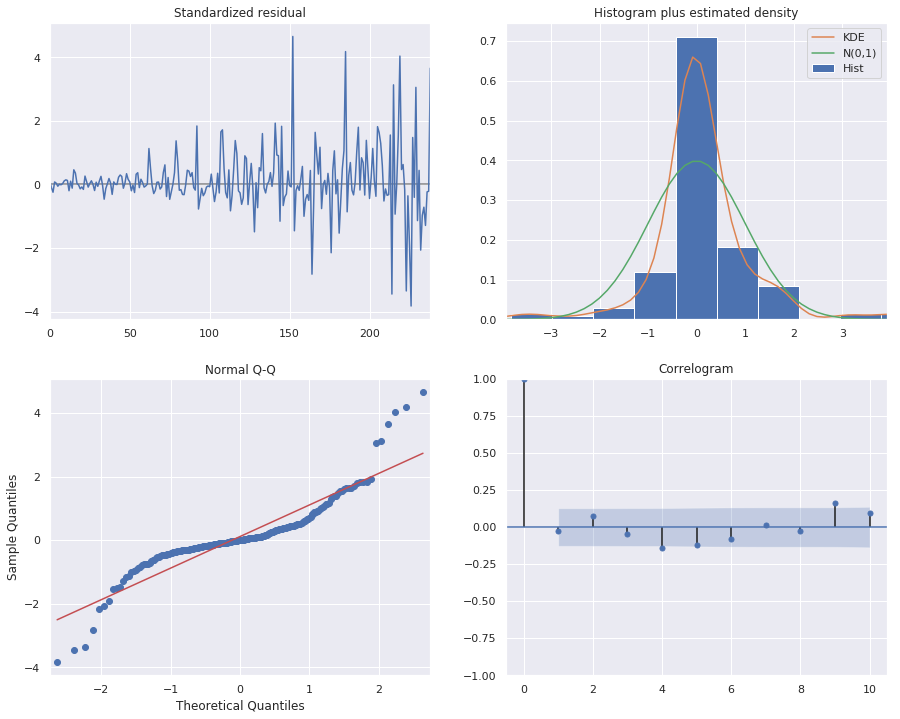

In [29]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
dfl_MP.reset_index(inplace=True)

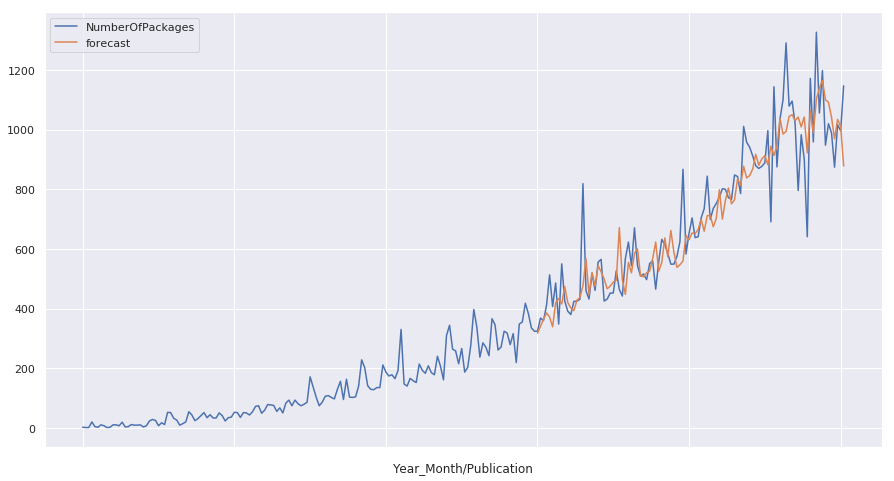

In [31]:
dfl_MP['forecast'] = results.predict(start = 150)  
dfl_MP.set_index('Year_Month/Publication')[['NumberOfPackages', 'forecast']].plot(figsize=(15, 8))

In [46]:
import math
from sklearn.metrics import mean_squared_error

RMS = math.sqrt(mean_squared_error(dfl_MP['NumberOfPackages'][151:], dfl_MP['forecast'][151:]))
RMS

105.16082443903726

Un buen desempeño del modelo está representado por valores bajos de RMSE. Un valor de RMSE = 0 indica un ajuste perfecto entre la serie observada y la serie estimada. 

In [47]:
# Obtiene un pronóstico de 100 pasos por delante en el futuro

pred_uc = results.get_forecast(steps=60)

# Intervalo de confianza
pred_ci = pred_uc.conf_int()

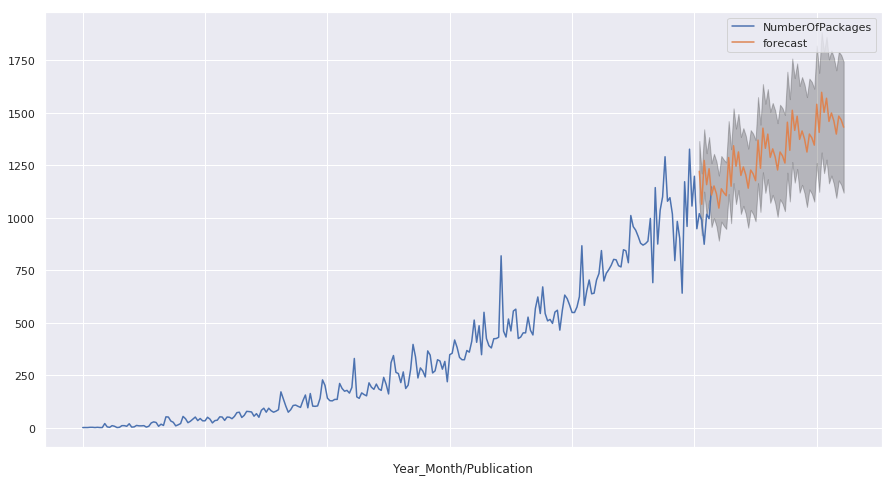

In [45]:
ax = dfl_MPC.set_index('Year_Month/Publication')[['NumberOfPackages']].plot(label='Observed', figsize=(15, 8))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()

In [50]:
dfl_MP.tail(50)

,index,Year_Month/Publication,NumberOfPackages,Year/Publication,first_difference,seasonal_first_difference,forecast
202,202,2015-11-01,638,2015,-66.0,-159.0,651.176000
203,203,2015-12-01,641,2015,3.0,-71.0,665.202907
204,204,2016-01-01,704,2016,63.0,80.0,698.666433
205,205,2016-02-01,735,2016,31.0,62.0,659.567050
206,206,2016-03-01,844,2016,109.0,144.0,711.660418
207,207,2016-04-01,699,2016,-145.0,-145.0,711.990266
208,208,2016-05-01,736,2016,37.0,11.0,674.390444
209,209,2016-06-01,753,2016,17.0,-33.0,702.752754
210,210,2016-07-01,774,2016,21.0,-221.0,798.604748
211,211,2016-08-01,802,2016,28.0,312.0,700.078980


In [40]:
versionByPkg = df.groupby('Package')[['Version']].count()
versionByPkg = versionByPkg.rename(columns={'Version': 'NumberOfVersions'})
versionByPkg.reset_index(inplace=True)
versionByPkg.sort_values('NumberOfVersions', ascending=False, inplace=True)
versionByPkg.shape

(15369, 2)

In [41]:
# Obtenemos el número de versiones global de los paquetes a lo largo del tiempo
u_versions = df[['Package','DatePublication','Year/Publication','Month/Publication', 'Year_Month/Publication']].copy()
#versionsByPackages = u_versions.groupby('Package')[['Package']].count()
#versionsByPackages = versionsByPackages.rename(columns={'Package': 'NumberOfVersions'})
#versionsByPackages.reset_index(inplace=True)
#versionsByPackages.head()
# Filtra los paquetes que tienen más de una versión
filter_packages = versionByPkg[versionByPkg['NumberOfVersions'] != 1]
df_updates = pd.merge(filter_packages, u_versions, how='left', on=['Package'])

# Para eliminar la primera versión que se lanzó del paquete y crear un nuevo df de los paquetes nuevos 
# lanzados por mes
df_updates['DatePublication_Shift'] = df_updates.groupby('Package')['DatePublication'].shift(1)

# Nuevas versiones lanzadas por mes
### Paquetes que tienen una versión
pkg_unique_version = versionByPkg[versionByPkg['NumberOfVersions'] == 1]

### Obtiene la primera versión del paquete
firsts_versions = df_updates[df_updates['DatePublication_Shift'].isnull()]
new_versions = pkg_unique_version.append(firsts_versions, ignore_index = True, sort=False)

# Agrupa por año/mes y cuenta el número de nuevas versiones
new_versionsByMonth = new_versions.groupby('Year_Month/Publication')[['Package']].count()
df_updates.dropna(inplace=True) # Elimina la primera versión del paquete
df_updates.head()

,Package,NumberOfVersions,DatePublication,Year/Publication,Month/Publication,Year_Month/Publication,DatePublication_Shift
1,Matrix,198,2000-07-18,2000,7,2000-07,2000-07-15
2,Matrix,198,2000-07-24,2000,7,2000-07,2000-07-18
3,Matrix,198,2000-08-11,2000,8,2000-08,2000-07-24
4,Matrix,198,2000-08-11,2000,8,2000-08,2000-08-11
5,Matrix,198,2000-10-30,2000,10,2000-10,2000-08-11


In [42]:
# Obtiene el número de actualizaciones de versiones de los paquetes por mes
updatesByMonth = df_updates.groupby(['Year_Month/Publication'])[['Package']].count()
updatesByMonth = updatesByMonth.rename(columns={'Package': 'NumberOfVersionUpdates'}) 
updatesByMonth.reset_index(inplace=True)
updatesByMonth.head()

,Year_Month/Publication,NumberOfVersionUpdates
0,1999-07,8
1,1999-08,6
2,1999-09,1
3,1999-10,1
4,1999-11,7
